# 正则化weight_decay(L2正则)

正则化就是**减少方差**的策略。

误差=偏差+方差+噪声
- 偏差：度量学习算法的期望预测与真实结果的偏离程度，刻画学习算法本身的拟合能力。
- 方差：度量同样大小的训练集的变动导致学习性能的变化，刻画数据扰动所造成的影响。
- 噪声：表达了在当前任务上任何学习算法所能达到的期望泛化误差的下界。
<img style="float: center;" src="images/174.png" width="70%">

过拟合现象就是高方差。
<img style="float: center;" src="images/175.png" width="70%">

正则化就是减少方差，有利于解决过拟合的问题。

正则化的思想就是在目标函数中加入正则项：$Obj=Cost+Regularization$

其中，$Cost=\frac{1}{N}\sum^N_if(\hat{y_i},y_i)$

正则有两种：
- L1正则：$\sum^N_i|w_i|$
- L2正则：$\sum^N_iw^2_i$

加上正则项，就是希望代价函数小，同时希望$w_i$小，这样说明每个样本的权重都很小，模型就不会太多地关注某种类型地样本，模型参数也不会太复杂，有利于缓解过拟合现象。

下图展示了L1和L2正则：
- 左边L1正则，上面彩色是Cost等高线图，即同一条线上Cost是相等的，比如A，B，C三点。黑色的矩形表示L1正则项的一个等高线，$|w_1|+|w_2|=r$，其中r为1，则矩形框上任意一个点产生的正则项都是1。A、B、C三点的目标函数，他们的Cost是相等的，则哪个点的Regularization最小呢？C的正则项是1，A和B的正则项都比C大，所以C的目标函数最小。
  - 所以如果在L1的情况下找个最优解，既能损失最小，又能权重最小，则往往这个最优解发生在坐标轴上（即C点）。
  - 注意，C点的$w_1$等于0，说明参数解有0项，$w_1$消失了。
  - 所以L1正则项一般会产生稀疏的解，也就是有0项的解。
  - 这是因为加上L1之后，参数的解往往会发生在坐标轴上导致某些参数的值为0
- 右边L2正则，彩色的圈是Cost等高线，下面黑色的圈是L2正则等高线（$|w_1^2|+|w_2^2|=1$），如果在A'，B'，C'点确定最优解的化，依然是C'点，因为它在Cost相等的情况下正则最小。
  - 但是发现L2正则下不会出现某个参数为0的情况，而是$w_1$和$w_2$都比较小。
  - 所以L2正则项的最优参数值很小概率出现在坐标轴上，因此每一维的参数都不会是0.
  - 当最小化$\|w\|$时，就会使每一项趋近于0
<img style="float: center;" src="images/176.png" width="70%">

L1正则特点：
- 不容易计算，在零点连续但不可导，需要分段求导
- **L1模型可以将一些权值缩小到零（稀疏）**
- 执行隐式变量选择，意味着一些变量值对结果的影响降为0，就像删除它们一样
- 其中一些预测因子对应较大权值，而其余的（几乎归零）
- 由于它可以提供稀疏的解决方案，因此通常时建模特征数量巨大时的首选模型
- 它任意选择高度相关特征中的任何一个，**并将其余特征对应的系数减少到0**
- **L1范数对于异常值更具有抵抗力**

L2正则特点：
- 容易计算，可导，适合基于梯度的方法
- 将一些权值缩小到接近0
- 相关预测特征对应的系数值相似
- 当特征数量巨大时，计算量会比较大
- 对于有相关特征存在的情况，**它会包含所有这些相关的特征**，但是相关特征的权值分布取决于相关性
- **对异常值非常敏感**
- 相对于L1正则会更加准确

PyTorch中，L2正则又叫权值衰减（weight decay）：

原来的更新公式：

$w_{i+1}=w_i-\frac{\partial Loss}{\partial w_i}$

目标函数加上一个L2正则项：$Obj=Loss+\frac{\lambda}{2}*\sum^N_i w_i^2$，则参数的更新方式改变成下面：

$w_{i+1}=w_i-\frac{\partial obj}{\partial w_i}=w_i-\left(\frac{\partial Loss}{\partial w_i}+\lambda*w_i\right)=w_i(1-\lambda)-\frac{\partial Loss}{\partial w_i}$

$\lambda$取值是0-1，即每一次迭代后，参数$w_i$本身也会发生一个衰减，即加上L2正则项与没有加L2正则项进行一个对比，加入L2正则项，这里的$w_i$就会发生数值上的一个衰减。（故这也是L2正则项称为权值衰减的原因）

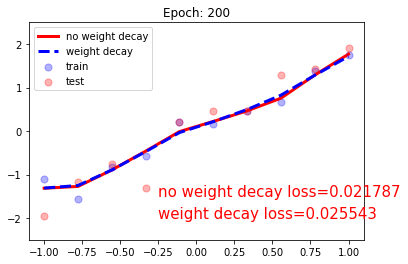

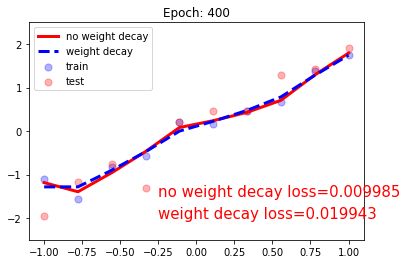

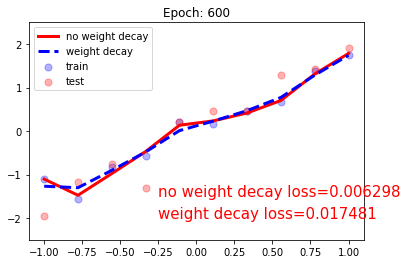

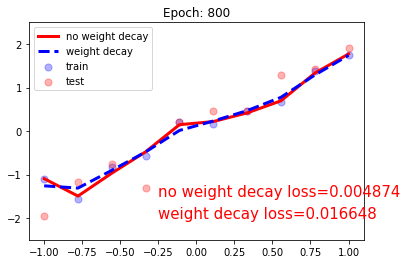

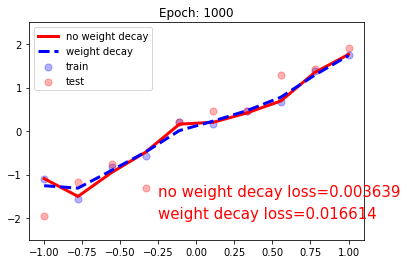

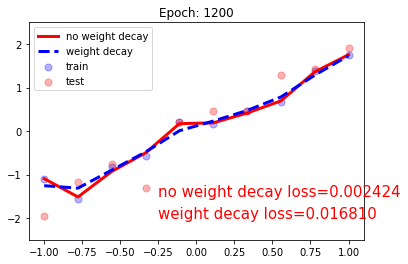

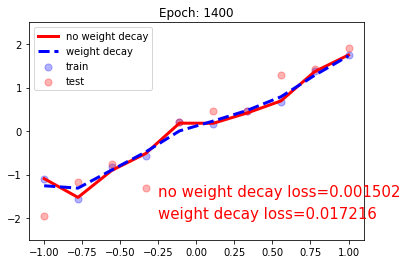

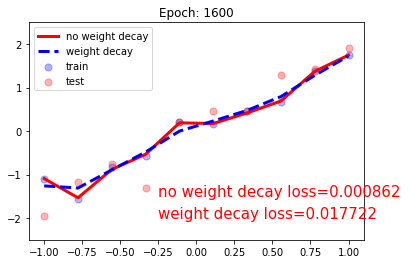

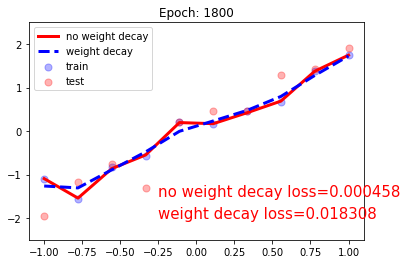

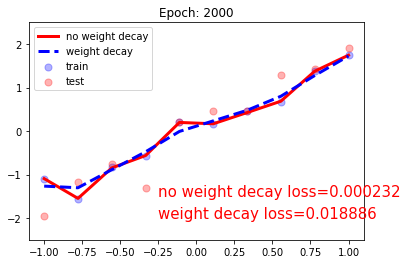

In [1]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#============== step 1/5 数据 ================
def gen_data(num_data=10, x_range=(-1, 1)):
    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w * train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w * test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))

#===============step 2/5 模型================
class MLP(nn.Module):
    def __init__(self, neural_num):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, 1)
            )
    def forward(self, x):
        return self.linears(x)

# 这里建立两个模型，一个不带正则，一个带正则
net_normal = MLP(neural_num=200)
net_weight_decay = MLP(neural_num=200)

#===================step 3/5 优化器 ===================
optim_normal = torch.optim.SGD(net_normal.parameters(), lr=0.01, momentum=0.9)
optim_wdecay = torch.optim.SGD(net_weight_decay.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-2)

#===================step 4/5  损失函数================
loss_func = torch.nn.MSELoss()

#===================step 5/5 迭代训练===================
writer = SummaryWriter(comment='_test tensorboard', filename_suffix='12345678')
for epoch in range(2000):
    # forward
    pred_normal, pred_decay = net_normal(train_x), net_weight_decay(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_decay, train_y)

    optim_normal.zero_grad()
    optim_wdecay.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_wdecay.step()

    if (epoch+1) % 200 == 0:
        # 可视化
        for name, layer in net_normal.named_parameters():
            writer.add_histogram(name+'_grad_normal', layer.grad, epoch)
            writer.add_histogram(name+'_data_normal', layer, epoch)

        for name, layer in net_weight_decay.named_parameters():
            writer.add_histogram(name+'_grad_weight_decay', layer.grad, epoch)
            writer.add_histogram(name+'_data_weight_decay', layer, epoch)

        test_pred_normal, test_pred_wdecay = net_normal(test_x), net_weight_decay(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_normal.data.numpy(), 'r-', lw=3, label='no weight decay')
        plt.plot(test_x.data.numpy(), test_pred_wdecay.data.numpy(), 'b--', lw=3, label='weight decay')
        plt.text(-0.25, -1.5, 'no weight decay loss={:.6f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'weight decay loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

可以发现，不带正则化的红色线发生了过拟合现象。

通过Tensorboard观察梯度参数的分布情况，这里可以明显看出衰减：
- 左边：不带正则化的模型参数分布情况，可以看到从迭代开始到结束整个权值分布都没有变化
- 右边：加入weight decay分布，可以看到衰减的趋势，说明L2正则起作用了，在迭代过程中权值不断缩减，以至于模型不会过于复杂产生过拟合
<img style="float: center;" src="images/177.png" width="70%">

L2正则实现过程：

在optim_wdecay.step()打上断点，然后debug步入，进入sgd的step方法：
<img style="float: center;" src="images/178.png" width="70%">

# 正则化Dropout

## 概念

Dropout（随机失活），给一个概率（随机），让某个神经元的权重为0（失活）：
<img style="float: center;" src="images/179.png" width="70%">

每一层，随机指定一些神经元不起作用，相当于把网络进行简化，过拟合主要因为网络太复杂，参数太多，并且后面层的网络可能过于依赖前层的某个神经元。

加入Dropout后，网络会变得简单，减少一些参数，并且由于不知道前层哪些神经元会失活，导致后面的网络不敢放太多的权重在前层的某个神经元，这样就减轻了过度依赖现象，对特征少了依赖，有利于缓解过拟合。

注意：**数据的尺度变化**，只在训练的时候使用Dropout，在测试的时候不用Dropout，即模型训练的时候会随机失活一部分神经元，而测试的时候用所有的神经元。则测试的时候会出现数据尺度的问题，因此**所有权重需要乘上1-drop_prob，以保证训练和测试时尺度变化一致。**

假设输入100个特征，则第一层的第一个神经元表达式为：$Z^1_1=\sum^100_{i=1}w_ix_i$
- 假设不失活，这里假设$w_ix_i=1$，则第一个神经元$Z^1_1=100$
- 当失活时，假设失活率drop_prob=0.3，即输入约30%不起作用，则$Z^1_1=\sum^{70}_{i=1}w_ix_i=70$

发现，使用Dropout后，比不失活少了30，尺度缩小了，然而测试的时候使用的是全部的神经元，尺度会变成100，这就导致模型在数值上有了一个差异。

因此**在测试的时候，需要所有的权重都乘以1-drop_prob**，测试集相当于$Z^1_{1test}=\sum^{100}_{i=1}(0.7*w_i)x_i=0.7*100=70$
<img style="float: center;" src="images/180.png" width="70%">

这样采用Dropout的训练集和不采用Dropout的测试集的尺度就变成一致了。

## nn.Dropout

torch.nn.Dropout(p=0.5, inplace=False)

- p：失活概率

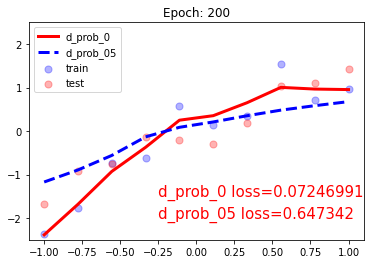

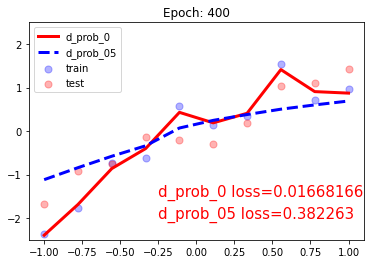

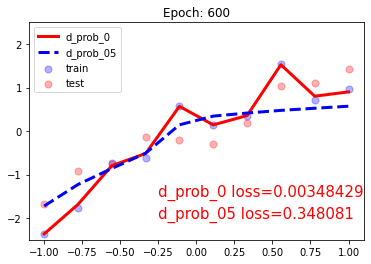

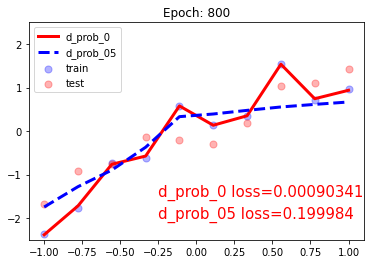

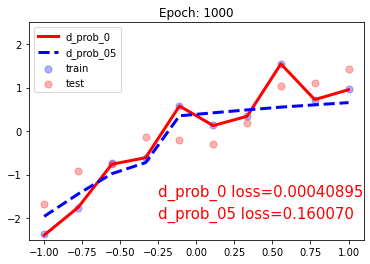

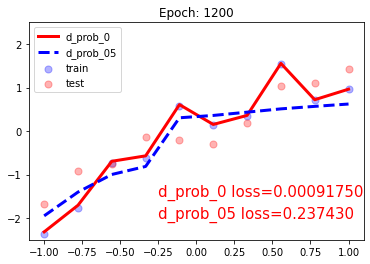

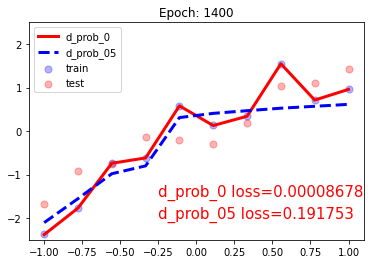

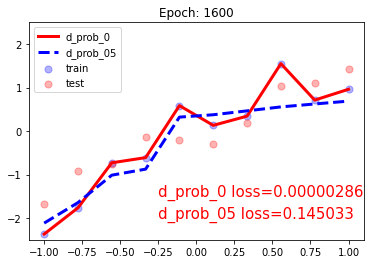

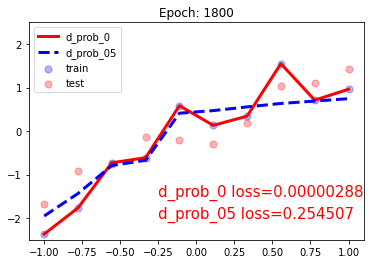

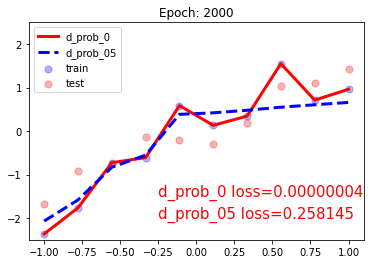

In [2]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#============== step 1/5 数据 ================
def gen_data(num_data=10, x_range=(-1, 1)):
    w = 1.5
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = w * train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = w * test_x + torch.normal(0, 0.3, size=test_x.size())

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))

#===============step 2/5 模型================
class MLP(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(MLP, self).__init__()
        
        self.linears = nn.Sequential(
            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),
            
            # Dropout接在第二个Linear之前
            # Dropout通常放在需要Dropout网络的前一层
            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            
            nn.Dropout(d_prob),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            
            # 通常输出层的Dropout是不加的
            # 这里由于数据太简单了才加上
            nn.Dropout(d_prob),
            nn.Linear(neural_num, 1)
        )
    def forward(self, x):
        return self.linears(x)

# 这里建立两个模型，一个不失活，一个0.5概率失活
net_prob_0 = MLP(neural_num=200, d_prob=0.)
net_prob_05 = MLP(neural_num=200, d_prob=0.5)

#===================step 3/5 优化器 ===================
optim_normal = torch.optim.SGD(net_prob_0.parameters(), lr=0.01, momentum=0.9)
optim_wdecay = torch.optim.SGD(net_prob_05.parameters(), lr=0.01, momentum=0.9)

#===================step 4/5  损失函数================
loss_func = torch.nn.MSELoss()

#===================step 5/5 迭代训练===================
writer = SummaryWriter(comment='_test tensorboard', filename_suffix='12345678')
for epoch in range(2000):
    # forward
    pred_normal, pred_decay = net_prob_0(train_x), net_prob_05(train_x)
    loss_normal, loss_wdecay = loss_func(pred_normal, train_y), loss_func(pred_decay, train_y)

    optim_normal.zero_grad()
    optim_wdecay.zero_grad()

    loss_normal.backward()
    loss_wdecay.backward()

    optim_normal.step()
    optim_wdecay.step()

    if (epoch+1) % 200 == 0:
        
        # Dropout在训练和测试阶段不一样，这时候需要对网络设置一个状态
        # eval()函数表示网络即将使用测试状态
        # 设置测试状态之后，才能用测试数据去测试网络，
        # 否则网络怎么知道啥时候测试啥时候训练？
        net_prob_0.eval()
        net_prob_05.eval()
        
        # 可视化
        for name, layer in net_prob_0.named_parameters():
            writer.add_histogram(name+'_grad_normal', layer.grad, epoch)
            writer.add_histogram(name+'_data_normal', layer, epoch)

        for name, layer in net_prob_05.named_parameters():
            writer.add_histogram(name+'_grad_weight_decay', layer.grad, epoch)
            writer.add_histogram(name+'_data_weight_decay', layer, epoch)

        test_pred_prob_0, test_pred_prob_05 = net_prob_0(test_x), net_prob_05(test_x)

        # 绘图
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_prob_0.data.numpy(), 'r-', lw=3, label='d_prob_0')
        plt.plot(test_x.data.numpy(), test_pred_prob_05.data.numpy(), 'b--', lw=3, label='d_prob_05')
        plt.text(-0.25, -1.5, 'd_prob_0 loss={:.8f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'd_prob_05 loss={:.6f}'.format(loss_wdecay.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

        # 告诉网络接下来要进入训练状态
        net_prob_0.train()
        net_prob_05.train()

上面代码要注意两点：
- Dropout放置的位置：放在要用的层的前面
- Dropout操作模型训练和测试是不一样的，需要调整网络的状态（eval，train）

从图中可以看到，不带正则化的红色线发生了过拟合现象，并且Dropout效果与L2正则差不多。

通过Tensorboard观察梯度参数的分布情况，可以看出Dropout有利于收缩权重的分布：
<img style="float: center;" src="images/181.png" width="70%">

对比Dropout和L2正则：
<img style="float: center;" src="images/182.png" width="70%">

注意，PyTorch使用Dropout时，是权重乘以$\frac{1}{1-p}$，即除以$1-p$，这样就不用在测试时候权重乘以$1-p$了，也没有改变原来数据的尺度。

即：$Z^1_{1train}=\sum^{70}_{i=1}\left(\frac{70}{0.7}w_i\right)x_i=100$，$Z^1_{1test}=\sum^{100}_{i=1}w_ix_i=100$

# 标准化BatchNormalization

## 简介

BatchNoramlization：批标准化，批指mini-batch，标准化即均值0方差1。

论文：《BatchNormalization：Accelerating Deep Network Train by Reducing Internal Covariate Shift》

https://arxiv.org/pdf/1502.03167.pdf

优点：
- 可以用更大学习率，加速模型收敛
- 可以不用精心设计权值初始化
- 可以不用Dropout或者较小的Dropout
- 可以不用L2或者较小的weight decay
- 可以不用局部响应标准化（AlexNet中用到）

BatchNormalization算法流程：
<img style="float: center;" src="images/183.png" width="70%">

最后的仿射变换，可以增强模型的容纳能力，使得模型自身更加灵活，让模型自判断是否需要去改变数据的一个分布（这里的$\gamma,\beta$类似于神经网络权值$w,b$）。

如果模型发现分布不是太好，就让$\gamma=\sqrt{\sigma^2_{\mathcal{B}}+\epsilon},\beta=\mu_\mathcal{B}$，这样$y_i$依然等于$x_i$，没有改变分布。（这就是仿射变换的功能，提供了一个可逆操作，需不需要改变数据分布，把这个权利交给模型自己学习）

BN本来是解决Internal Covariate Shift这个问题，即网络输出层的数值尺度变化导致网络无法训练：
<img style="float: center;" src="images/184.png" width="70%">

之前的公式：
<img style="float: center;" src="images/185.png" width="40%">

发现每一层的方差是前面所有层方差的连乘，如果有一层尺度异常，则随着网络加深，很容易引起梯度消失或爆炸。

所以权值初始化就考虑用一种初始化的方式控制网络输出层的尺度。

BN的提出，也是为了解决这个问题，当然解决了这个问题之后，竟然发现带来了一系列的优点。

In [3]:
class MLP(nn.Module):
    def __init__(self, neural_num, layers=100):
        super(MLP, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(neural_num, neural_num, bias=False) for i in range(layers)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(neural_num) for i in range(layers)])
        self.neural_num = neural_num

    def forward(self, x):

        for (i, linear), bn in zip(enumerate(self.linears), self.bns):
            x = linear(x)
            x = bn(x)
            x = torch.relu(x)

            if torch.isnan(x.std()):
                print("output is nan in {} layers".format(i))
                break

            print("layers:{}, std:{}".format(i, x.std().item()))

        return x

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):

                # method 1
                # nn.init.normal_(m.weight.data, std=1)    # normal: mean=0, std=1

                # method 2 kaiming
                nn.init.kaiming_normal_(m.weight.data)


neural_nums = 256
layer_nums = 100
batch_size = 16

net = MLP(neural_nums, layer_nums)
# net.initialize()

inputs = torch.randn((batch_size, neural_nums))  # normal: mean=0, std=1

output = net(inputs)
print(output)

layers:0, std:0.5793972015380859
layers:1, std:0.5886762142181396
layers:2, std:0.5702381134033203
layers:3, std:0.5795726776123047
layers:4, std:0.578118085861206
layers:5, std:0.5805989503860474
layers:6, std:0.5805166959762573
layers:7, std:0.5878894329071045
layers:8, std:0.5843016505241394
layers:9, std:0.5778878927230835
layers:10, std:0.582299530506134
layers:11, std:0.5725270509719849
layers:12, std:0.5735965967178345
layers:13, std:0.5745078921318054
layers:14, std:0.5815242528915405
layers:15, std:0.5867782831192017
layers:16, std:0.5846875905990601
layers:17, std:0.5890974998474121
layers:18, std:0.5833401083946228
layers:19, std:0.5808956623077393
layers:20, std:0.570223867893219
layers:21, std:0.5717909932136536
layers:22, std:0.5808613300323486
layers:23, std:0.5796762704849243
layers:24, std:0.5798394680023193
layers:25, std:0.5726718902587891
layers:26, std:0.5849117040634155
layers:27, std:0.5788204669952393
layers:28, std:0.5810612440109253
layers:29, std:0.5789002180

首先如果不用权值初始化，不用BN，则网络会出现的问题：
<img style="float: center;" src="images/186.png" width="70%">

加上权值初始化，由于用到了ReLU函数，因此使用Kaiming初始化方法：
<img style="float: center;" src="images/187.png" width="70%">

如果不用权值初始化，而用BN呢，可以发现依然保证了数据的尺度，并且好处是不用考虑用什么样的方法进行权值初始化：
<img style="float: center;" src="images/188.png" width="70%">

以下是人民币二分类实验中的各个条件的情况：
<img style="float: center;" src="images/189.png" width="70%">

可以看出BN层的作用，约束特征输入层的一个尺度范围，让它保持一个良好的分布，使得模型训练起来更加简单。

## PyTorch中的BatchNormalization

PyTorch中提供三种BatchNorm方法：
- nn.BatchNorm1d
- nn.BatchNorm2d
- nn.BatchNorm3d

上面三个BatchNorma方法都继承\_\_BatchNorm基类：

\_\_init\_\_(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
- num_features：样本特征数量
- eps：分母修正项
- momentum：指数加权平均估计当前mean/var
- affine：是否需要仿射变换
- track_running_stats：训练状态/测试状态
  - momentum那里有个均值和方差
    - 如果是训练状态，需要重新估计均值和方差
    - 如果是测试状态，就用训练时候统计的均值和方差

BatchNorm三个方法也有属性：
- running_mean：均值
- running_var：方差
- weight：仿射变换中的$\gamma$
- bias：仿射变换中的$\beta$
- 分别对应公式：
  - $\hat{x_i}\leftarrow\frac{x_i-\mu_{\mathcal{\beta}}}{\sqrt{\sigma^2_{\mathcal{\beta}}+\epsilon}}$
  - $y_i\leftarrow \gamma\hat{x_i}+\beta \equiv BN_{\gamma,\beta}(x_i)$
  
此处均值和方差采用指数加权平均进行计算，不仅要考虑当前mini-batch的均值和方差，还考虑上一个mini-batch均值和方差（当然仅在训练时，测试时还是用当前的统计值）
- running_mean = (1-momentum) * pre_running_mean + momentum * mean_t
- running_var = (1-momentum) * pre_running_var + momentum * var_t


### nn.BatchNorm1d

input = 样本数 * 特征数 * 1d特征
<img style="float: center;" src="images/190.png" width="70%">

In [4]:
batch_size = 3    # 3个样本
num_features = 5    # 5个特征
momentum = 0.3     # 这个计算后面均值，方差的时候用到

features_shape = (1)   # 我们特征的维度是1

# 1D，一个特征
feature_map = torch.ones(features_shape)
# 2D，一列数据
feature_maps = torch.stack([feature_map * (i + 1) for i in range(num_features)], dim=0)
# 3D，上面那3列数据
feature_maps_bs = torch.stack([feature_maps for i in range(batch_size)], dim=0)
print("input data:\n{} shape is {}".format(feature_maps_bs, feature_maps_bs.shape))

# BN1d在这里定义
bn = nn.BatchNorm1d(num_features=num_features, momentum=momentum)

# 这个得初始化,毕竟我们这是第一次迭代
running_mean, running_var = 0, 1

for i in range(2):
    outputs = bn(feature_maps_bs)

    print("\niteration:{}, running mean: {} ".format(i, bn.running_mean))
    print("iteration:{}, running var:{} ".format(i, bn.running_var))

    mean_t, var_t = 2, 0

    # 采用滑动平均方式计算均值和方差
    running_mean = (1 - momentum) * running_mean + momentum * mean_t
    running_var = (1 - momentum) * running_var + momentum * var_t

    print("iteration:{}, 第二个特征的running mean: {} ".format(i, running_mean))
    print("iteration:{}, 第二个特征的running var:{}".format(i, running_var))

input data:
tensor([[[1.],
         [2.],
         [3.],
         [4.],
         [5.]],

        [[1.],
         [2.],
         [3.],
         [4.],
         [5.]],

        [[1.],
         [2.],
         [3.],
         [4.],
         [5.]]]) shape is torch.Size([3, 5, 1])

iteration:0, running mean: tensor([0.3000, 0.6000, 0.9000, 1.2000, 1.5000]) 
iteration:0, running var:tensor([0.7000, 0.7000, 0.7000, 0.7000, 0.7000]) 
iteration:0, 第二个特征的running mean: 0.6 
iteration:0, 第二个特征的running var:0.7

iteration:1, running mean: tensor([0.5100, 1.0200, 1.5300, 2.0400, 2.5500]) 
iteration:1, running var:tensor([0.4900, 0.4900, 0.4900, 0.4900, 0.4900]) 
iteration:1, 第二个特征的running mean: 1.02 
iteration:1, 第二个特征的running var:0.48999999999999994


可以看到下面结果：
<img style="float: center;" src="images/191.png" width="70%">

结果中看到，当前mini-batch所得到的用于对数据进行Normalize的均值，不是当前mini-batch得到的均值，而是会考虑前面mini-batch的数据信息，加权平均的一个均值和方差。

可以在调试里看到BN里四个参数：均值，方差，$\gamma$，$\beta$，以及它们的形状：
<img style="float: center;" src="images/192.png" width="70%">

### nn.BatchNorm2d

input = 样本数 * 特征数 * 2d特征
<img style="float: center;" src="images/193.png" width="70%">

卷积图像中经常是这种2d的。

### nn.BatchNorm3d

input = 样本数 * 特征数 * 3d特征
<img style="float: center;" src="images/194.png" width="70%">

在时空序列中会用到

## 其他Normalization方法

常见的Normalization有四种：
- Batch Normalization（BN）
- Layer Normalization（LN）
- Instance Normalization（IN）
- Group Normalization（GN）

相同点（公式上都相同）：
- $\hat{x_i}\leftarrow\frac{x_i-\mu_{\mathcal{\beta}}}{\sqrt{\sigma^2_{\mathcal{\beta}}+\epsilon}}$
- $y_i\leftarrow \gamma\hat{x_i}+\beta \equiv BN_{\gamma,\beta}(x_i)$

不同点（求取$\mu_{\mathcal{B}}$和$\sigma_{\mathcal{B}}$不同）：
- BatchNormalization：batch上计算均值和方差
- LayerNormalization：以层为单位去计算均值和方差
- Instance Normalization：在图像生成方法中使用的一个方法
- Group Normalization：按组为单位计算均值和方差

### Layer Normalization

https://arxiv.org/pdf/1607.06450v1.pdf

BN不适用于变长网络，如RNN，所以提出了逐层计算均值和方差的思路
<img style="float: center;" src="images/195.png" width="70%">

BN与LN区别：
- LN中同层神经元输入拥有相同的均值和方差，不同的输入样本有不同的均值和方差
- BN中则针对不同神经元输入计算均值和方差，同一个batch中的输入拥有相同的均值和方差

在LN中，没有running_mean和running_var，并且$\gamma$和$\beta$为逐元素

PyTorch中的LN：
- nn.LayerNorm(normalized_shape, eps=1e-05, elementwise_affine=True)
  - normalized_shape：该层形状，这是最重要的。
  - eps：分母修正项
  - elementwise_affine：是否需要仿射变换

LN常用在RNN中，在CNN和FCN中效果不如BN
<img style="float: center;" src="images/196.png" width="70%">

结果：
<img style="float: center;" src="images/197.png" width="70%">

从结果中可以看出，LN与BN的区别：
- LN是以层为单位的，而BN是以Batch为单位的

如果把参数elementwise_affine设置为False，则：
- 会报错误：AttributeError：'NoneType' object has no attribute 'shape'

normalized_shape，这个可以自己指定，但需要注意一定要从最后维度开始：
- 否则会报错：RuntimeError: Given normalized_shape=[6, 3], expected input with shape [* , 6, 3], but got input of size[8, 6, 3, 4]
<img style="float: center;" src="images/198.png" width="70%">

### Instance Normalization

https://arxiv.org/pdf/1607.08022.pdf

起因：BN在图像生成中不适用

思路：逐个Instance（channel）计算均值和方差

比如图像风格迁移中，每一个样本的风格是不一样的，所以我们不能像BN那样从多个样本里去计算平均值和方差。
<img style="float: center;" src="images/199.png" width="70%">

PyTorch中IN的使用：
- nn.InstanceNorm2d(num_features, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  - num_features：一个样本的特征数量（最重要）
  - eps：分母修正项
  - momentum：指数加权平均估计当前的均值和方差
  - affine：是否需要仿射变换
  - track_running_stats：训练状态还是测试状态

代码：
<img style="float: center;" src="images/200.png" width="70%">

结果：
<img style="float: center;" src="images/201.png" width="70%">

### Group Normalization

https://arxiv.org/pdf/1803.08494.pdf

起因：小batch样本中，BN估计的值不准

思路：数据不够，通道来凑。同样适用于大模型（小batch size）的任务
<img style="float: center;" src="images/202.png" width="70%">

有点像LN，相当于LN进行分组，与LN一样不再有running_mean和running_var，$\gamma$和$\beta$为逐个通道。

PyTorch中的GN：
- nn.GroupNorm(num_groups, num_channels, eps=1e-05, affine=True)
  - num_groups：分组数
  - num_channels：通道数（特征数）
  - eps：分母修正项
  - affine：是否需要仿射变换

前两个参数是必须的，否则机器不知道要咋分组，每组多少个。

提供了组数和通道数，两者的商就代表一组多少个特征图，这样从一组中求均值和方差。

注意分组时要能整除。

代码：
<img style="float: center;" src="images/203.png" width="70%">

### 总结

以上就是四种标准化方法了，BN，LN，IN和GN都是为了克服Internal Covariate Shift（ICS）提出来的，计算公式差不多，只不过计算均值和方差的时候采用的方式不同。

神图，这个图把四维的数据画成了三维的：
<img style="float: center;" src="images/204.png" width="70%">

同时可以结合这个图进行比较：
<img style="float: center;" src="images/205.png" width="70%">

参考博客：https://blog.csdn.net/liuxiao214/article/details/81037416

# 思维导图

<img style="float: center;" src="images/206.png" width="70%">